In [4]:
# MOD 1: needed to append sys path to import holodeck
import sys
sys.path.append('C:/Users/emiga/OneDrive/Cal/Anisotropies/code/holodeck')

# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
import holodeck.gravwaves
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode

log = holo.log
log.setLevel(logging.INFO)

# Quick-Start

Create an Illustris-Based Population, and a simple binary-evolution model

In [5]:
# ---- Create initial population

pop = holo.population.Pop_Illustris()

# ---- Evolve binary population

# create a fixed-total-time hardening mechanism
fixed = holo.evolution.Fixed_Time.from_pop(pop, 2.0 * GYR)
# Create an evolution instance using population and hardening mechanism
evo = holo.evolution.Evolution(pop, fixed)
# evolve binary population
evo.evolve()

12:39:19 INFO : calculating normalization exactly [evolution.py:__init__]


Calculate GWB

In [6]:
# construct sampling frequencies
freqs = holo.utils.nyquist_freqs(dur=20.0*YR, cad=0.3*YR)
# calculate discretized GW signals
gwb = holo.gravwaves.GW_Discrete(evo, freqs, nreals=30)
gwb.emit()

12:50:27 ERROR : `GW_Discrete` will not work properly with unevenly sampled frequency (log-space)! [gravwaves.py:__init__]
NoneType: None


GW frequencies:   0%|          | 0/33 [00:00<?, ?it/s]

Plot GWB

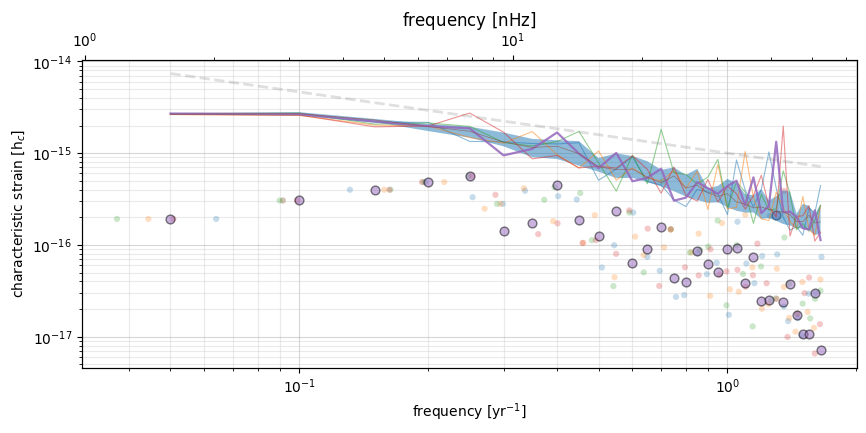

In [7]:
plot.plot_gwb(gwb)
plt.show()

# Population Modifiers (`_Population_Modifier`)

## Resample (`PM_Resample`)

Apply a modifier to resample binary population by some factor, increasing the number of sample points

In [7]:
mod_resamp = holo.population.PM_Resample(resample=2.0)
old_size = pop.size
pop.modify(mod_resamp)
print(f"Population size increased from {old_size} to {pop.size} elements")

Population size increased from 2749 to 5498 elements


Plot resampled population, now with many more points

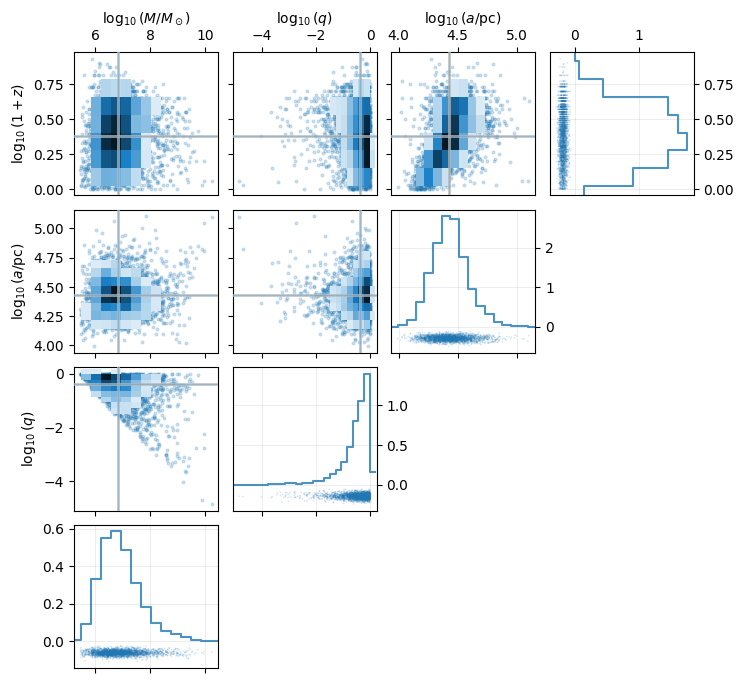

In [8]:
plot.plot_bin_pop(pop)
plt.show()

## Mass Reset (`PM_Mass_Reset`)

Apply another `Modifier` to change the MBH masses to match a particular M-Mbulge relation

In [9]:
# Create the modifier using M-Mbulge relation
mmbulge = holo.relations.MMBulge_KH2013()
mod_KH2013 = holo.population.PM_Mass_Reset(mmbulge, scatter=True)

# Choose percentiles for reporting statistical properties
percs = 100*sp.stats.norm.cdf([-1, 0, 1])
percs = [0,] + percs.tolist() + [100,]

# Format nicely
str_array = lambda xx: ", ".join(["{:.2e}".format(yy) for yy in xx])
str_masses = lambda xx: str_array(np.percentile(xx/MSOL, percs))

# Modify population
print(f"                {0:7.0f}% {16:7.0f}% {50:7.0f}% {84:7.0f}% {100:7.0f}%")
print("Masses before: ", str_masses(pop.mass))
pop.modify(mod_KH2013)
print("Masses after : ", str_masses(pop.mass))

                      0%      16%      50%      84%     100%
Masses before:  8.91e+04, 5.68e+05, 2.55e+06, 1.80e+07, 2.25e+10
Masses after :  2.65e+04, 1.04e+06, 6.23e+06, 4.77e+07, 3.18e+10


Plot MBH-Galaxy scaling relationship, showing old and new masses (i.e. before and after modification)

Plotting 3.0e+03/1.1e+04 data-points


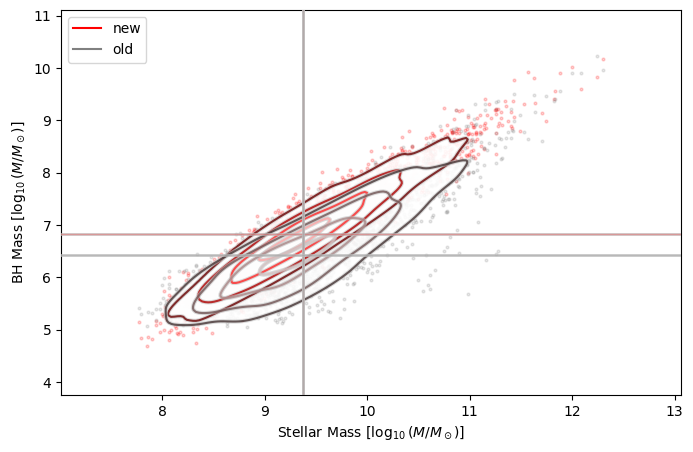

In [10]:
plot.plot_mbh_scaling_relations(pop)
plt.show()

## Eccentricity (`PM_Eccentricity`)

Demonstrate the eccentricity function

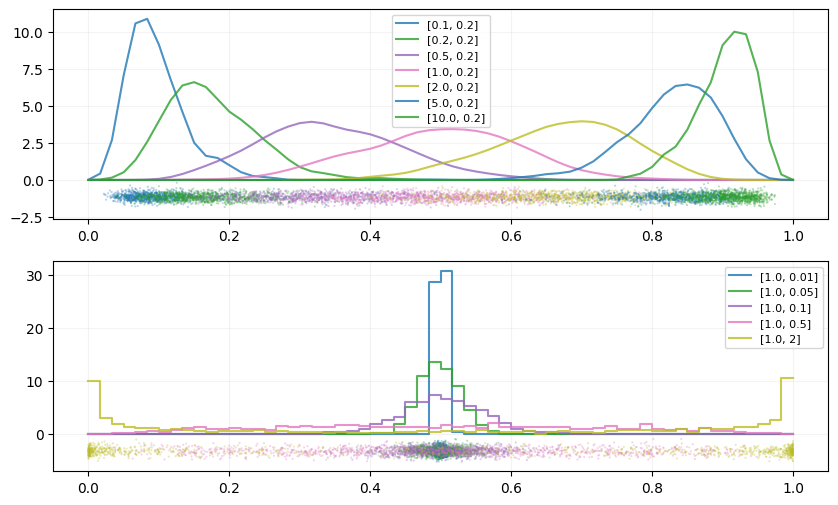

In [11]:
DEF_VALS = [1.0, 0.2]
NUM = 1e3

edges = np.linspace(0.0, 1.0, 61)
kw = dict(hist=False, density=True, edges=edges)

fig, axes = plt.subplots(figsize=[10, 6], nrows=2)
for ax in axes:
    ax.grid(alpha=0.15)
    
ax = axes[0]
handles = []
labels = []
for cent in [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]:
    vals = [vv for vv in DEF_VALS]
    vals[0] = cent
    ecc = holo.population.PM_Eccentricity(vals)
    xx = ecc._random_eccentricities(NUM)
    hh = kale.dist1d(xx, ax=ax, **kw)
    handles.append(hh)
    labels.append(vals)
    
ax.legend(handles, labels, fontsize=8)


ax = axes[1]
kw = dict(hist=True, density=False, edges=edges)
handles = []
labels = []
for wid in [0.01, 0.05, 0.1, 0.5, 2]:
    vals = [vv for vv in DEF_VALS]
    vals[1] = wid
    ecc = holo.population.PM_Eccentricity(vals)
    xx = ecc._random_eccentricities(NUM)
    hh = kale.dist1d(xx, ax=ax, **kw)
    handles.append(hh)
    labels.append(vals)
    
ax.legend(handles, labels, fontsize=8)

plt.show()

Add eccentricity to binary population, plot all initial binary parameters

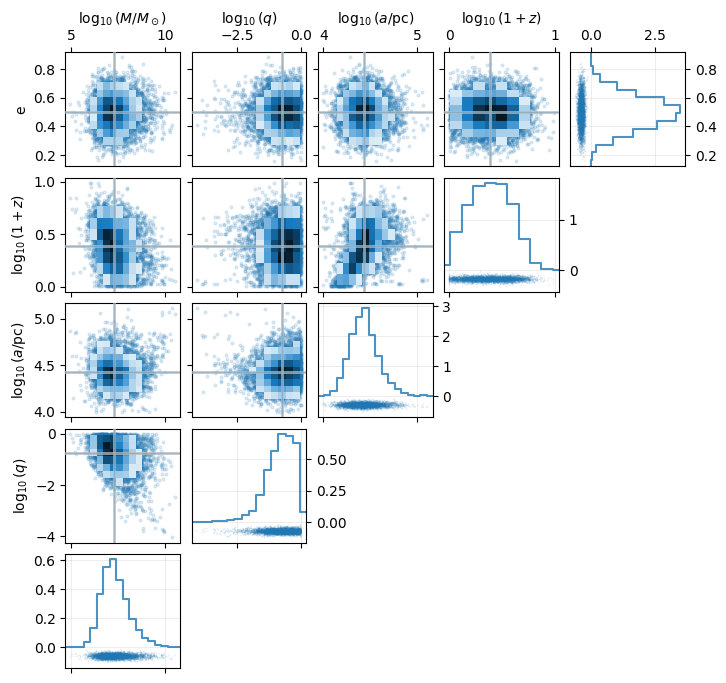

In [12]:
ecc = holo.population.PM_Eccentricity()
pop.modify(ecc)
plot.plot_bin_pop(pop)
plt.show()

# Binary Evolution Models

## Phenomenological 'Fixed Time' Evolution Model

The `holodeck.evolution.Fixed_Time` class uses a simple parametrized hardening model that forces all binaries to coalesce in a given total amount of time.  It uses a double power-law in hardening timescale [i.e. $\tau_a \equiv a / (da/dt) = dt/d\ln a$], with two power-law indices, and a transition binary-separation, as the parameters.  Based on those three parameters, it constructs a complete binary evolution history for each binary (including GW emission), and chooses a normalization such that the total evolution time matches the desired value.

Construct an `Evolution` instance using a `Fixed_Time` model for the given lifetime.

In [13]:
# Set timescale for all binaries to merge over
fix_time = 3.0 * GYR
# ---- Construct hardening model with this desired merging time
# When this instance is created, it calculates the appropriate hardening normalization for each
# binary to reach the desired coalescing time
fixed = holo.evolution.Fixed_Time.from_pop(pop, fix_time)
# Construct evolution instance using fixed time hardening
evo = holo.evolution.Evolution(pop, fixed)
# Evolve population
evo.evolve()

23:29:22 INFO : calculating normalization exactly [evolution.py:__init__]


calculating hardening normalization:   0%|          | 0/6 [00:00<?, ?it/s]

Compare resulting lifetimes to the targeted lifetime.  The match won't be perfect, but it should be within a few percent of the desired timescale (`fix_time`).

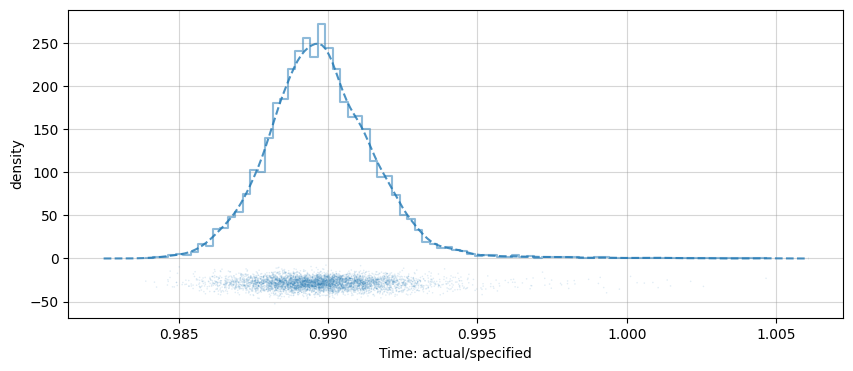

In [14]:
# Calculate the total lifetime of each binary
time = evo.tlook
dt = time[:, 0] - time[:, -1]

# Create figure
fig, ax = plot.figax(scale='lin', xlabel='Time: actual/specified', ylabel='density')
# use kalepy to plot distribution
kale.dist1d(dt/fix_time, density=True)

plt.show()

Plot the hardening timescale ($\tau_a$) vs. binary separation ($a$).

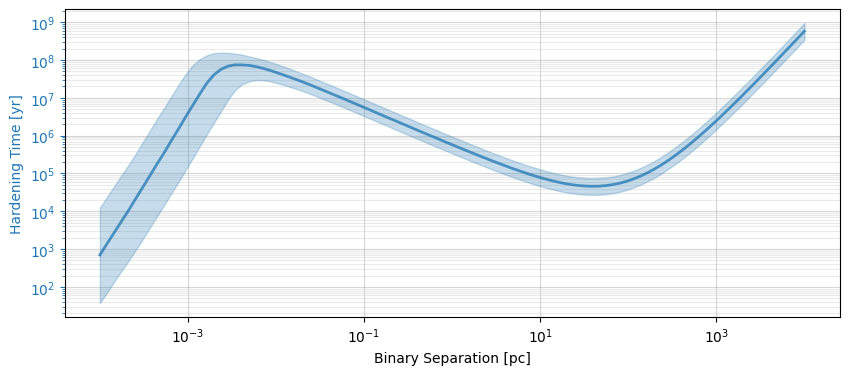

In [15]:
# Create spacing in separation (xaxis) to plot against
sepa = np.logspace(-4, 4, 100) * PC
# Plot hardening rates
plot.plot_evo(evo, sepa=sepa)

plt.show()

Plot the hardening timescale ($\tau_f$) vs. binary frequency ($f$).

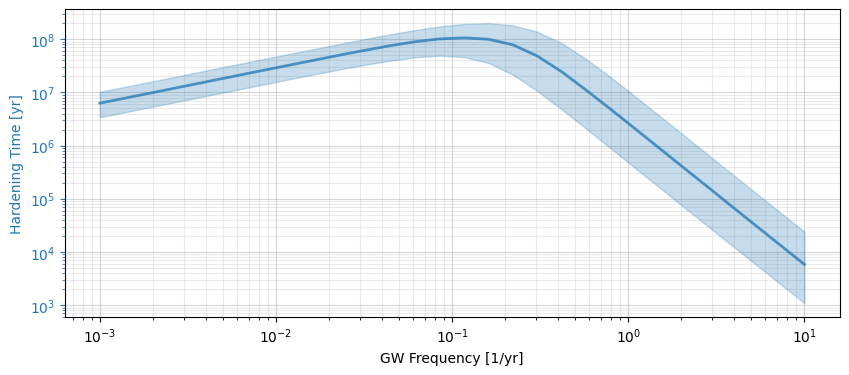

In [16]:
# Create frequency spacing (xaxis) to plot against
freqs = np.logspace(-3, 1, 30) / YR
# plot evolution
plot.plot_evo(evo, freqs=freqs)
plt.show()

Calculate GWB from the `evolution` instance, which takes into account the fixed-time hardening model

In [17]:
gwb = holo.gravwaves.GW_Discrete(evo, freqs, nreals=5)
gwb.emit()

GW frequencies:   0%|          | 0/30 [00:00<?, ?it/s]

Plot GWB.

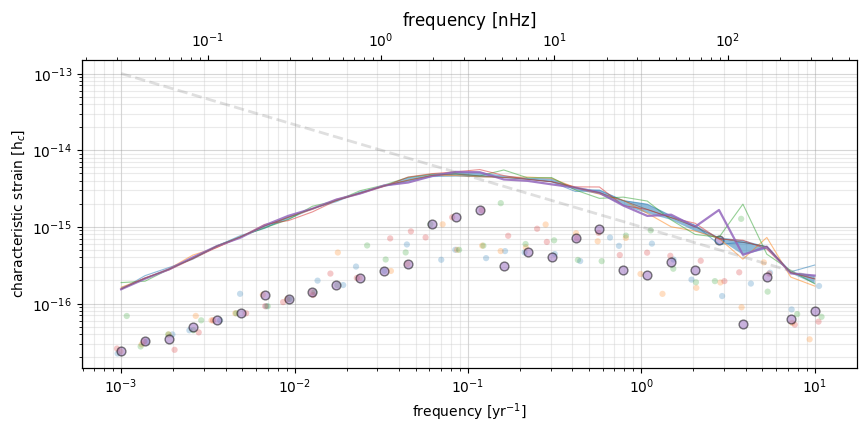

In [18]:
plot.plot_gwb(gwb)
plt.show()